<h1><center>Seminární práce - Soft computing</center></h1>
<h3><center>Milan Gittler</center></h3>
<hr/>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import tree

from typing import Any

<h3><center>Rozhodovací strom</center></h3>
<hr/>

Rozhodovací stromy jsou jedním z typů modelů strojového učení, které lze použít jak pro klasifikační, tak regresní úlohy. Základní myšlenkou rozhodovacích stromů je rekurzivní dělení dat podle rozhodovacích uzlů. V každém uzlu rozhodovacího stromu algoritmus vybírá vlastnost, která nejlépe odděluje data na základě nějakého kritéria (např. informačního zisku nebo Giniho nečistoty). Vlastnost s nejvyšším skóre je vybrána jako rozdělující vlastnost. Data jsou pak rozdělena do podmnožin na základě hodnot vybrané vlastnosti. Tento proces se opakuje, dokud není splněno kritérium pro zastavení, jako je například, že všechny instance v uzlu patří do stejné třídy nebo strom dosáhl maximální hloubky. Jakmile je rozhodovací strom postaven, lze ho použít k predikci nových dat. Pro provedení predikce je nutné, aby data prošla sestaveným stromem, kde každý uzel rozhodne, o jaký druh dat se jedná. Konečná predikce je založena na listu, do kterého data propadnou.

Jednou z výhod rozhodovacích stromů je, že jsou snadno interpretovatelné a vizualizovatelné. Struktura stromu usnadňuje pochopení rozhodovacího procesu a identifikaci, které vlastnosti jsou nejdůležitější pro predikci. Rozhodovací stromy jsou také relativně rychlé na trénování a mohou zpracovávat jak kategoriální, tak spojitá data. Nicméně, rozhodovací stromy mohou trpět přeučením, pokud je strom příliš složitý, což vede ke špatné obecnosti na nových datech.

Rozhodovací strom implementovaný níže vytváří stromový model, který rekurzivně dělí vstupní data na základě vlastnosti, která maximalizuje informační zisk na každém uzlu. Algoritmus může pracovat s kategoriálními i spojitými daty. Hyperparametry max_depth a min_samples_split ovládají hloubku stromu a minimální počet vzorků potřebný k rozdělení uzlu. Parametr mode ovládá, zda se použije entropie nebo Giniho nečistota pro výpočet informačního zisku.

$$ \text{Entropie: } H(S) = -\sum_{i=1}^{c} p_i \log_2 p_i $$
$$ \text{Giniho nečistota: } G(S) = 1 - \sum_{i=1}^{c} p_i^2 $$
$$ \text{Informační zisk: } IG(S, A) = H(S) - \sum_{v \in V(A)} \frac{|S_v|}{|S|} H(S_v) $$

In [3]:
class Node:
    def __init__(
        self, feature_index: int = None, threshold: float = None, left_child: 'Node' = None, right_child: 'Node' = None,
        depth: int = None, info_gain: float = None, is_leaf: bool = False, value: float = None
    ) -> None:
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.depth = depth
        self.info_gain = info_gain
        self.is_leaf = is_leaf
        self.value = value

In [4]:
class DecisionTree:
    def __init__(
        self, max_depth: int = np.inf, min_samples_split: int = 2, mode: str = "entropy"
    ) -> None:
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.mode = mode
        self.root = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        self._label_name = 'label'
        X[self._label_name] = y
        self.root = self._build_tree(X)
    
    def predict(self, X: pd.DataFrame):
        return [self._predict(row, self.root) for _, row in X.iterrows()]

    def _predict(self, row, node: Node) -> list:
        if node.is_leaf:
            return node.value
        
        feature_val = row[node.feature_index]

        if feature_val <= node.threshold:
            return self._predict(row, node.left_child)
        else:
            return self._predict(row, node.right_child)
    
    def _build_tree(self, df: pd.DataFrame | np.ndarray, depth: int = 0) -> Node:
        if depth == 0:
            self._column_headers = df.columns
            self._feature_types = self._determine_types_of_features(df)
            data = df.to_numpy()
        else:
            data = df           
        
        if self._check_purity(data) or (len(data) < self.min_samples_split) or (depth == self.max_depth):
            classification = self._classify(data) 
            return Node(
                value=classification,
                depth=depth,
                is_leaf=True
            )
        else:
            potential_splits = self._all_potential_splits(data)
            best_split = self._best_split(data,potential_splits)
            left_dataset, right_dataset = self._split_data(data, best_split['feature_index'], best_split['threshold'])
            
            if len(left_dataset) == 0 or len(right_dataset) == 0:
                classification = self._classify(data)
                return Node(
                    value=classification,
                    depth=depth,
                    is_leaf=True
                )

            node = Node(
                feature_index=best_split['feature_index'],
                threshold=best_split['threshold'],
                depth=depth,
                info_gain=best_split['info_gain']
            )
            
            depth += 1
            left_child = self._build_tree(left_dataset, depth)
            right_child = self._build_tree(right_dataset, depth)
            
            node.left_child = left_child
            node.right_child = right_child
            return node
        
    def _best_split(self, data: np.ndarray, potential_splits):
        # Vybere takový sloupce s takovou unikátní hodnotou, která přináší nejvěší informační zisk.
        # Tento postup se nazývá bruteforce nebo
        best_split = {}
        best_info_gain = -np.inf
        for index in potential_splits:
            for value in potential_splits[index]:
                left_dataset, right_dataset = self._split_data(data=data, split_column=index, split_value=value)
                curr_info_gain = self._information_gain(data, [left_dataset, right_dataset])
                if curr_info_gain > best_info_gain:
                    best_split["feature_index"] = index
                    best_split["threshold"] = value
                    best_split["info_gain"] = curr_info_gain
                    best_info_gain = curr_info_gain
        
        return best_split

    def _split_data(self, data: np.ndarray, split_column: int, split_value: float | int) -> tuple:
        # Data jsou rozdělena na levý a pravý dataset podle unikátní hodnoty z daného sloupce.
        column_values = data[:, split_column]
        type_of_feature = self._feature_types[split_column]
    
        if type_of_feature == "continuous":
            # Vrátí všechny řádky, které splňují podmínku
            left_dataset = data[column_values <= split_value]
            right_dataset = data[column_values > split_value]
        else:
            left_dataset = data[column_values == split_value]
            right_dataset = data[column_values != split_value]
        return left_dataset, right_dataset
    
    def _all_potential_splits(self, data: np.ndarray) -> dict:
        # Tato funkce hledá v každém sloupci unikátní hodnoty
        potential_splits = {}
        _, n_column = data.shape
        for col_index in range(n_column - 1):
            unique_values = np.unique(data[:, col_index])
            potential_splits[col_index] = unique_values
        return potential_splits

    def _determine_types_of_features(self, df: pd.DataFrame, n_unique_values_treshold: int = 10):
        feature_types = []
        
        for feature in df.columns:
            if feature != self._label_name:
                unique_values = df[feature].unique()

                if len(unique_values) <= n_unique_values_treshold:
                    feature_types.append("categorical")
                else:
                    feature_types.append("continuous")
        
        return feature_types

    def _classify(self, data: np.ndarray) -> Any:
        unique_classes, unique_count = np.unique(data[:, -1], return_counts=True)

        class_index = unique_count.argmax()
        return unique_classes[class_index]

    def _check_purity(self, data: np.ndarray) -> bool:
        if len(np.unique(data[:, -1])) == 1:
            return True
        
        return False 

    def print_tree(self, node: Node) -> None:
        indent = " " * node.depth * 4
        if node.is_leaf:
            print(f'{indent} Leaf node: {node.value}')
        else:
            print(indent + f"Split on column {node.feature_index} <= {node.threshold}")
            print(indent + "Left:")
            self.print_tree(node.left_child)
            print(indent + "Right:")
            self.print_tree(node.right_child)
        
    def _entropy(self, data: np.ndarray) -> float:
        _, counts = np.unique(data[:, -1], return_counts=True)
        probs = counts /counts.sum()
        return -(probs * np.log2(probs)).sum()
    
    def _gini_impurity(self, data: np.ndarray) -> float:
        _, counts = np.unique(data[:, -1], return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)
    
    def _information_gain(self, parent: np.ndarray, children: list[np.ndarray]) -> float:
        f = self._entropy if self.mode == "entropy" else self._gini_impurity
        child_impurity = np.sum([len(child) / len(parent) * f(child) for child in children])
        return f(parent) - child_impurity

In [5]:
decision_tree = DecisionTree()

In [6]:
X, y = datasets.load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

decision_tree.fit(X_train.copy(), y_train)
decision_tree.print_tree(decision_tree.root)

Split on column 2 <= 1.9
Left:
     Leaf node: 0.0
Right:
    Split on column 2 <= 4.7
    Left:
        Split on column 3 <= 1.6
        Left:
             Leaf node: 1.0
        Right:
             Leaf node: 2.0
    Right:
        Split on column 3 <= 1.8
        Left:
            Split on column 2 <= 5.1
            Left:
                Split on column 0 <= 6.3
                Left:
                    Split on column 0 <= 6.0
                    Left:
                        Split on column 1 <= 2.7
                        Left:
                             Leaf node: 1.0
                        Right:
                            Split on column 1 <= 3.0
                            Left:
                                 Leaf node: 2.0
                            Right:
                                 Leaf node: 1.0
                    Right:
                         Leaf node: 2.0
                Right:
                     Leaf node: 1.0
            Right:
                 Leaf

In [7]:
y_pred = decision_tree.predict(X_test)
for i, test in enumerate(y_test):
    print(f'{test} => {y_pred[i]}')
acc = accuracy_score(y_test, y_pred)
print(f' Tree accuracy: {acc}')

0 => 0.0
0 => 0.0
2 => 2.0
1 => 1.0
0 => 0.0
2 => 2.0
1 => 1.0
2 => 2.0
0 => 0.0
1 => 1.0
1 => 1.0
2 => 2.0
1 => 2.0
1 => 1.0
1 => 1.0
1 => 1.0
2 => 2.0
1 => 1.0
1 => 1.0
2 => 2.0
0 => 0.0
2 => 2.0
0 => 0.0
1 => 1.0
0 => 0.0
0 => 0.0
0 => 0.0
1 => 1.0
0 => 0.0
2 => 1.0
 Tree accuracy: 0.9333333333333333


In [8]:
sk_tree = tree.DecisionTreeClassifier()
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)
sk_acc = accuracy_score(y_test, sk_pred)
print(f' Tree accuracy: {sk_acc}')

 Tree accuracy: 0.9


<h3><center>Naivní Bayesovský klasifikátor</center></h3>
<hr/>

Naivní Bayesovský klasifikátor je metoda strojového učení založená na Bayesově teorému (větě), který slouží k výpočtu pravděpodobností určitých událostí na základě známých informací o těchto událostech. Naivní Bayesovský klasifikátor se nazývá naivním, protože se uvádí zjednodušený předpoklad, že atributy, které jsou využity pro klasifikaci dat jsou navzájem nezávislé, jinak řečeno, každý z těchto atributů přispívá nezávisle k pravděpodobnosti, že určitá třída je ta správná, nehledě na hodnoty ostatních atributů. 

Algoritmus nejprve vypočítá pravděpodobnost každé třídy na základě vstupních vlastností. Toto se nazývá aposteriorní pravděpodobnost. Poté je třída s nejvyšší aposteriorní pravděpodobností vybrána jako předpovídaná třídní štítek pro vstupní data.

Pro výpočet aposteriorní pravděpodobnosti třídy na základě vstupních vlastností naivní Bayes spoléhá na Bayesovu větu, která říká:
$$P(C | x) = \frac{P(x | C) \times P(C)}{P(x)} $$

kde:

- $P(C | x)$ je aposteriorní pravděpodobnost třídy C vstupní vlastnosti $x$
- $P(x | C)$ je pravděpodobnost pozorování vstupních vlastností $x$ za předpokladu třídy $C$
- $P(C)$ je apriorní pravděpodobnost třídy $C$
- $P(x)$ je pravděpodobnost pozorování vstupních vlastností $x$

Jak bylo řečeno výše, algoritmus předpokládá, že vlastnosti jsou za předpokladu nezávislé vzhledem k třídním labelům, takže pravděpodobnost pozorování vstupních vlastností x za předpokladu třídy C lze vyjádřit jako součin podmíněných pravděpodobností každé vlastnosti:
$$ P(x | C) = P(x_1 | C) \times P(x_2 | C) \times \ldots \times P(x_n | C)$$

Apriori pravděpodobnost třídy C lze odhadnout jako poměr trénovacích dat, které patří do třídy C ku celkovým počtem. Pravděpodobnost pozorování vstupních vlastností x lze vypočítat jako součet součinů apriorní pravděpodobnosti a pravděpodobnosti pozorování pro všechny možné třídní labely:
$$ P(x) = \sum_{i=1}^{n} P(x | C_i) \times P(C_i) $$

In [9]:
class NaiveBayes():
    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._classes = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self._classes)

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        # Výpočet střední hodnoty, rozptylu a apriorní pravděpodobnosti pro každou třídu
        for i, c in enumerate(self._classes):
            X_c: pd.DataFrame = X[y == c]
            self._mean[i, :] = X_c.mean(axis=0)
            self._var[i, :] = X_c.var(axis=0)
            self._priors[i] = X_c.shape[0] / n_samples

    def predict(self, X: pd.DataFrame):
        y_pred = [self._classify(x) for _, x in X.iterrows()]
        return np.array(y_pred)
    
    def _calculate_gaussian_likelihood(self, x, mean, var):
        eps = 1e-4 # Zabránění dělení nulou
        numerator = np.exp(-((x - mean) * (x - mean) / (2 * var + eps)))
        dominator = np.sqrt(2.0 * np.pi * var + eps)
        return numerator / dominator

    def _classify(self, x):
        # Výpočet aposteriorní pravděpodobnosti pro každou třídu
        posteriors = []
        for i, _ in enumerate(self._classes):
            prior = np.log(self._priors[i])
            posterior = np.sum(np.log(self._calculate_gaussian_likelihood(x, self._mean[i], self._var[i])))
            posterior += prior
            posteriors.append(posterior)
            
        return self._classes[np.argmax(posteriors)]

In [10]:
naive_bayes = NaiveBayes()

In [11]:
X, y = datasets.load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [12]:
naive_bayes.fit(X_train, y_train)
pred = naive_bayes.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f' Naive Bayes accuracy: {acc}')

 Naive Bayes accuracy: 0.9666666666666667


<h3><center>Neuronová síť</center></h3>
<hr/>

Neuronová síť je typ algoritmu strojového učení, který je modelován podle struktury a funkce lidského mozku. Základním stavebním kamenem neuronové sítě je neuron, který přijímá vstupní 'signál' (data) od jiných neuronů nebo externích zdrojů dat, zpracovává je a produkuje výstupní signál. V neuronové síti jsou neurony organizovány do vrstev, přičemž každá vrstva obsahuje jeden nebo více neuronů. První vrstva neuronové sítě se nazývá vstupní vrstva, zatímco poslední vrstva se nazývá výstupní vrstva. Vrstvy mezi vstupní a výstupní vrstvou se nazývají skryté vrstvy. Každý neuron v neuronové síti má přidruženou sadu vah, které určují, jak silně každý vstupní signál přispívá k výstupu neuronu. Během trénování síť upravuje tyto váhy (a tzv. 'bias', který pomáhá při vytvoření ideálního dělení prostoru dat), aby zlepšila svou schopnost přesně klasifikovat nebo předpovídat data. 

Proces trénování neuronové sítě spočívá v předložení sady označených vstupní-výstupních párů, nazývaných trénovací data. Síť tato data používá k úpravě svých vah s cílem minimalizovat svou předpovědní chybu. Tento proces se obvykle provádí pomocí optimalizačního algoritmu, jako je gradientní sestup, který iterativně upravuje váhy v síti směrem ke snížení chyby.

V této seminární práci jsem se zaměřil na nejjednodušší typ neuronové sítě a to dopředné sítě. Jedná se o typ sítě, ve které informace proudí pouze jedním směrem od vstupních neuronů přes skryté neurony až k výstupním neuronům bez smyček nebo zpětné vazby. Proces přenosu informace v neuronové síti se nazývá předávací proces nebo feedforward proces. V tomto procesu při putování dat mezi vrstvami se používají tzv. aktivační funkce (například sigmoid, ReLU, softmax, ...), což jsou nelineární matematické funkce, které se aplikují na výstup každého neuronu v neuronové síti. Určují, zda by měli být neurony aktivovány tím, že transformují vstupní signál na výstupní signál, který bude předán další vrstvě neuronů. Aktivační funkce zavádí nelinearitu do sítě, umožňující jí učit se a modelovat složité vztahy mezi vstupními a výstupními daty.

Aby se síť mohla tzv. učit, neboli hledat ideální poměry vah, je nutné zjistit chybu aktuálního výstupu a v závislti na ní váhy aktualizovat. Pro tyto účely se využívá algotismus backpropagation. Název backpropagation vychází z toho, že zahrnuje propagaci chyb zpět skrz vrstvy sítě, aby se vypočetlo, jak moc každá váha a zkreslení přispívají k celkové chybě. Pro úpravu vah a nalezení optima se používá například stochastický gradientový sestup, jak bylo zmíněno výše. Bude tedy nutné znát směr největšího spádu neboli gradient. Během zpětné propagace je derivace šířena každou vrstvou neuronové sítě, aby byl vypočítán gradient ztrátové funkce (loss function - udává rozdíl mezi aktuální predikcí a skutečností) vzhledem k vahám a biasům této vrstvy.

Pro výpočet derivací se využívá tzv. chain rule neboli řetízkové pravidlo (popřípadě derivace složené funkce) $\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$. Ukažmě si na příkladu s neuronovou sítí o jedné skryté vrstvě, jak se toto pravidlo využívá:
$$ \text{Vstup do první vrstvy: } z_i = \sum_{j=1}^{n} w_{ij}^{(1)} x_j + b_i^{(1)} $$
$$ \text{Výstup z aktivační funkce: } a_i = \sigma(z_i) $$
$$ \text{Vstup do skryté vrstvy: } z_i = \sum_{i=1}^{n} w_{i}^{(2)} a_i + b^{(2)} $$
$$ \text{Výstup z aktivační funkce: } a_i = \sigma(z) $$
$$ \text{Mean squared error: } L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2 $$
$$ \frac{\partial L}{\partial w_{i}^{(2)}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial w_{i}^{(2)}} = (\hat{y} - y) \sigma'(z) a_i $$
$$ \frac{\partial L}{\partial b^{(2)}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial b^{(2)}} = (\hat{y} - y) \sigma'(z) $$
$$ \frac{\partial L}{\partial w_{ij}^{(1)}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial a_i} \cdot \frac{\partial a_i}{\partial z_i} \cdot \frac{\partial z_i}{\partial w_{ij}^{(1)}} = (\hat{y} - y) \sigma'(z) w_i^{(2)} \sigma'(z_i) x_j $$
$$ \frac{\partial L}{\partial b_i^{(1)}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial a_i} \cdot \frac{\partial a_i}{\partial z_i} \cdot \frac{\partial z_i}{\partial b_i^{(1)}} = (\hat{y} - y) \sigma'(z) w_i^{(2)} \sigma'(z_i) $$

$$ w_{ij}^{(1)} \leftarrow w_{ij}^{(1)} - \alpha \cdot \frac{\partial L}{\partial w_{ij}^{(1)}} $$
$$ b_i^{(1)} \leftarrow b_i^{(1)} - \alpha \frac{\partial L}{\partial b_i^{(1)}} $$

Pro trénování a testování sítě budeme používat jeden z nejznámějších datasetů MNIST, který se skládá z obrázků čísel od 0 do 9 - https://www.kaggle.com/competitions/digit-recognizer/overview

In [13]:
class ActivationFunction: 
    def __init__(self, type: str = 'relu'):
        match type:
            case 'relu':
                self.acti_fun = self._ReLU
            case 'sigmoid':
                self.acti_fun = self._sigmoid
            case 'softmax':
                self.acti_fun = self._softmax
            case _:
                self.acti_fun = self._ReLU

    def _sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / 1 + np.exp(-x)

    def _ReLU(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)
    
    def _softmax(self, x: np.ndarray) -> np.ndarray:
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.acti_fun(x)

In [14]:
class ActivationFunctionDerivative:
    def __init__(self, type: str = 'relu'):
        match type:
            case 'relu':
                self.deriv_acti_fun = self._deriv_ReLU
            case 'sigmoid':
                self.deriv_acti_fun = self._deriv_sigmoid
                self.acti_fun = ActivationFunction('sigmoid')
            case _:
                self.deriv_acti_fun = self._deriv_ReLU

    def _deriv_sigmoid(self, x: np.ndarray) -> np.ndarray:
        return self.acti_fun._sigmoid(x) * (1 - self.acti_fun._sigmoid(x))

    def _deriv_ReLU(self, x: np.ndarray) -> np.ndarray:
        return x > 0
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.deriv_acti_fun(x)

In [15]:
class DenseLayer:
    def __init__(self, n_inputs: int, n_outputs: int):
        self.weights = np.random.randn(n_inputs, n_outputs) * 0.1
        self.biases = np.zeros((1, n_outputs))

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.dot(x, self.weights) + self.biases

In [16]:
class NeuralNetwork:
    def __init__(
        self, layers: list, activation_fun: str = 'relu', batch_size: int = 10, learning_rate: float = 0.1, n_iter_msg: int = 10
    ) -> None:
        self.layers = layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_iter_msg = n_iter_msg
        self.loss = []
        self._activation_fun_deriv = ActivationFunctionDerivative(activation_fun)

    def forward(self, X: np.ndarray, y: np.ndarray, n_epoch: int) -> None:
        self.n_classes = np.max(y)
        self._gradient_descent(X, y, n_epoch)

    def make_predicitons(self, X: np.ndarray) -> np.ndarray:
        self._forward_prop(X)
        return self._get_predictions()

    def _gradient_descent(self, X: np.ndarray, y: np.ndarray, n_epoch: int) -> None:
        m = X.shape[1]
        for i in range(n_epoch + 1):
            for j in range(0, m, self.batch_size):
                X_batch = X[j:j+self.batch_size, :]
                y_batch = y[j:j+self.batch_size]
                self._forward_prop(X_batch)
                loss = self._back_prop(X_batch, y_batch)

            self.loss.append(loss)
            if i % self.n_iter_msg == 0:
                acc = self._get_accuracy(self._get_predictions(), y_batch)
                print(f'Epoch: {i} Loss: {self.loss[-1]} Accuracy: {acc}')


    def _forward_prop(self, X: np.ndarray) -> None:
        self._forw_results = [self.layers[0](X)]
        for i in range(1, len(self.layers)):
            self._forw_results.append(self.layers[i](self._forw_results[i-1]))

    def _back_prop(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        m = y.size
        one_hot_y = self._one_hot_encoding(y)
        pred_y = self._forw_results[-1]
        delta = (pred_y - one_hot_y)
        loss = self._cross_entropy_loss(pred_y, one_hot_y)
        for i in range(len(self.layers)-2, -1, -1):
            if isinstance(self.layers[i], ActivationFunction):
                delta = np.dot(delta, self.layers[i+1].weights) * self._activation_fun_deriv(self._forw_results[i-1])
            elif isinstance(self.layers[i], DenseLayer):
                dW = np.dot(X.T, delta) / m if i == 0 else np.dot(self._forw_results[i-1].T, delta) / m
                db = np.sum(delta) / m
                delta = np.dot(delta, self.layers[i].weights.T)

                self.layers[i].weights -= self.learning_rate * dW
                self.layers[i].biases -= self.learning_rate * db
        
        return loss

    def _cross_entropy_loss(self, pred_output: np.ndarray, expect_output: np.ndarray) -> np.ndarray:
        return -np.sum(expect_output * np.log(pred_output + 1e-12)) / expect_output.shape[1]

    def _one_hot_encoding(self, y: np.ndarray) -> np.ndarray:
        one_hot_y = np.zeros((y.size, self.n_classes + 1))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y

    def _get_predictions(self) -> np.ndarray:
        return np.argmax(self._forw_results[-1], axis=1)
    
    def _get_accuracy(self, pred: np.ndarray, y: np.ndarray) -> np.ndarray:
        return np.sum(pred == y) / y.size

Epoch: 0 Loss: 963.6803681186823 Accuracy: 0.10595238095238095
Epoch: 10 Loss: 945.9756907878567 Accuracy: 0.17904761904761904
Epoch: 20 Loss: 926.9510845420615 Accuracy: 0.2438095238095238
Epoch: 30 Loss: 901.3510433086001 Accuracy: 0.2897619047619048
Epoch: 40 Loss: 866.1149921880917 Accuracy: 0.315
Epoch: 50 Loss: 824.8550758719042 Accuracy: 0.3319047619047619
Epoch: 60 Loss: 785.2421281331954 Accuracy: 0.35404761904761906
Epoch: 70 Loss: 750.0825376784953 Accuracy: 0.3707142857142857
Epoch: 80 Loss: 717.4980999808798 Accuracy: 0.3911904761904762
Epoch: 90 Loss: 684.4892048685599 Accuracy: 0.4061904761904762
Epoch: 100 Loss: 651.406478622434 Accuracy: 0.4388095238095238
Epoch: 110 Loss: 619.9506936484306 Accuracy: 0.4795238095238095
Epoch: 120 Loss: 590.5335637987969 Accuracy: 0.5247619047619048
Epoch: 130 Loss: 562.9811864873109 Accuracy: 0.5497619047619048
Epoch: 140 Loss: 536.5748364796398 Accuracy: 0.5642857142857143
Epoch: 150 Loss: 511.7804995649849 Accuracy: 0.570952380952381

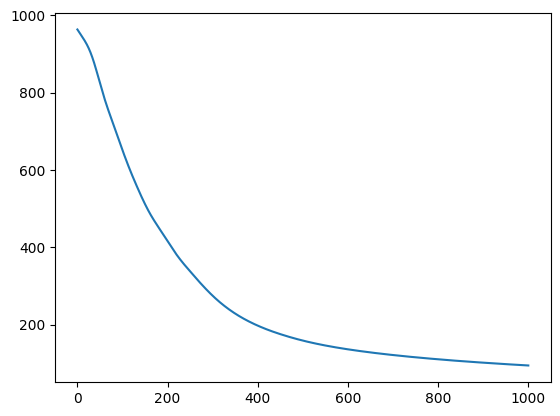

In [17]:
df = pd.read_csv('./train.csv')
data = df.to_numpy()

np.random.shuffle(data)
y_train = data[:, 0]
X_train = data[:, 1:]
X_train = X_train / 255

layers = [
    DenseLayer(784, 10), ActivationFunction('relu'), DenseLayer(10, 10), ActivationFunction('softmax')
]
nn = NeuralNetwork(layers, batch_size=4200, learning_rate=0.1, n_iter_msg=10)
nn.forward(X_train, y_train, 1000)

plt.plot(nn.loss)
plt.show()

In [20]:
pred = nn.make_predicitons(X_train[:10, :])
print(f'Prediciton: {pred} Truth: {y_train[:10]}')

Prediciton: [7 6 0 2 4 6 0 5 5 7] Truth: [7 6 0 2 4 6 0 5 5 7]


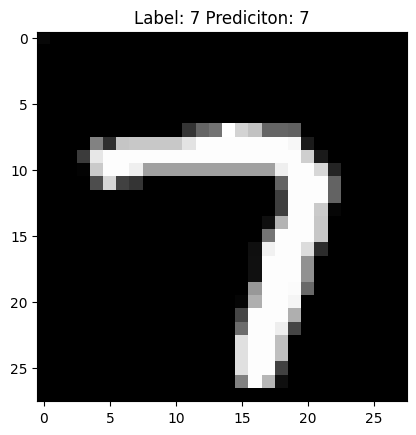

In [25]:
rnd_img_n = np.random.randint(0, data.shape[0])
x = data[rnd_img_n, :-1].flatten()
pred = nn.make_predicitons(x)
x_flat = x.flatten()
x_2d = np.reshape(x_flat, (28, 28))
plt.imshow(x_2d, cmap='gray')
plt.title(f'Label: {y_train[rnd_img_n]} Prediciton: {pred[0]}')
plt.show()

<h3><center>Zdroje:</center></h3>
<hr>

https://www.cis.upenn.edu/~danroth/Teaching/CS446-17/LectureNotesNew/dtree/main.pdf - Rohodovací strom  
https://www.youtube.com/watch?v=_L39rN6gz7Y - Rozhodovací strom  
https://github.com/Suji04/ML_from_Scratch/tree/master - Příklady implementace rozhodovacích stromů  

https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c - Naivní Bayes  
https://www.youtube.com/watch?v=O2L2Uv9pdDA&t - Naivní Bayes  

https://hagan.okstate.edu/NNDesign.pdf - Neuronová síť  
https://www.youtube.com/watch?v=hfMk-kjRv4c&t - Neuronová síť  
https://www.youtube.com/watch?v=w8yWXqWQYmU - Ukázka implementace základní neuronové sítě  